# IL027 Interdisciplinary Computer Modelling

## Lecture 10 - Advanced Machine Learning

### Michael Castelle - Centre for Interdisciplinary Methodologies

In [9]:
using Knet, Plots, Images
using ScikitLearn
@sk_import datasets: fetch_openml
gr(fmt=:png)

srand(1234); # seed random number generator for reproducible results

### New Stuff

In this notebook we introduce the following Julia/Knet packages and functions:

* Knet's function [conv4](https://knet.readthedocs.io/en/latest/cnn.html#convolution): Execute convolutions or cross-correlations using filters specified with `w` over tensor `x`.
* Knet's function [pool](https://knet.readthedocs.io/en/latest/cnn.html#pooling): Compute pooling of input values (i.e., the maximum or average of several adjacent values) to produce an output with smaller height and/or width.

## Convolutional neural networks (CNNs)

In the [previous lecture](L9-MachineLearning.ipynb), we connected the nodes of our neural networks in what seems like the simplest possible way. Every node in each layer was connected to every node in the subsequent layers. 

![](https://github.com/zackchase/mxnet-the-straight-dope/blob/master/img/multilayer-perceptron.png?raw=true)

This can require a lot of parameters! If our input were a 256x256 color image (still quite small for a photograph), and our network had 1,000 nodes in the first hidden layer, then our first weight matrix would require (256x256x3)x1000 parameters. That's nearly 200 million. Moreover the hidden layer would ignore all the spatial structure in the input image even though we know the local structure represents a powerful source of prior knowledge. 

Convolutional neural networks incorporate convolutional layers. These layers associate each of their nodes with a small window, called a *receptive field*, in the previous layer, instead of connecting to the full layer. This allows us to first learn local features via transformations that are applied in the same way for the top right corner as for the bottom left. Then we collect all this local information to predict global qualities of the image (like whether or not it depicts a dog). 

![](http://cs231n.github.io/assets/cnn/depthcol.jpeg)
(Image credit: Stanford cs231n http://cs231n.github.io/assets/cnn/depthcol.jpeg)

In short, there are two new concepts you need to grok here. First, we'll be introducting *convolutional* layers. Second, we'll be interleaving them with *pooling* layers. 

*First, we reuse (and slightly adapt) some functions from Lecture 9 for loading the digit data, splitting into training and test data, and defining "minibatches" of data.*

In [10]:
(X,y) = fetch_openml("mnist_784", version=1, return_X_y=true)
digits_data =reshape(X,(70000,1,28,28))
digits_y = [convert(String,y[n]) for n in 1:length(y)]
digits_targets = map(x->parse(Int64,x),digits_y)

function mnist_split_train_test(x,y,test)
    if test == 0
        xtrn = xtst = x
        ytrn = ytst = y
    else
        r = randperm(size(x,1))          # trn/tst split
        n = round(Int, (1-test) * size(x,1))
        xtrn=permutedims(x[r[1:n],:,:,:],(4,3,2,1))
        ytrn=y[r[1:n]]
        xtst=permutedims(x[r[n+1:end],:,:,:],(4,3,2,1))
        ytst=y[r[n+1:end]]
    end
    return (xtrn, ytrn, xtst, ytst)
end

function mnist_minibatch(x, y, batchsize; atype=Array{Float32}, 
                          xrows=28*28, yrows=10, xscale=255)
    # NOTE: this is changed from Lecture 9, since the 
    #   CNN requires 4D input arrays,
    #   rather than the 1D arrays used for a standard NN
    xbatch(a)=convert(atype, reshape(a./xscale, 28, 28, 1, batch_size))
    ybatch(a)=(a[a.==0]=10; 
               convert(atype, 
                       sparse(convert(Vector{Int},a),
                              1:length(a),one(eltype(a)),yrows,length(a))))
    xcols = div(length(x),xrows)
    xcols == length(y) || throw(DimensionMismatch())
    data = Any[]
    for i=1:batchsize:xcols-batchsize+1
        j=i+batchsize-1
        push!(data, (xbatch(x[1+(i-1)*xrows:j*xrows]), ybatch(y[i:j])))
    end
    return data
end

# extract and visualise image j from batch i
function mnist_view(d, i, j)
    println(d[i][2][:, j], "  -->  ", findfirst(d[i][2][:, j]))
    return Images.colorview(Images.Gray, d[i][1][:,:,1,j])
end

xtrn, ytrn, xtst, ytst = mnist_split_train_test(digits_data, digits_targets, 0.4);

In [11]:
num_samples = 1000
batch_size  = 10
dtrn = mnist_minibatch(xtrn[:, :, :, 1:num_samples], 
                       ytrn[1:num_samples], batch_size)
dtst = mnist_minibatch(xtst[:, :, :, 1:num_samples], 
                       ytst[1:num_samples], batch_size);

We can visualise the training data after grouping it into mini-batches, along with the associated "heat-vectors" used to encode the target values - note how there is a 1 in the index corresponding to the correct value.

Float32[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]  -->  5


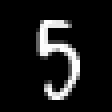

In [12]:
i = 1 # batch number
j = 2 # index within batch
mnist_view(dtrn, i, j)

##  Parameters

Each node in convolutional layer is associated with a 3D block (`height` x `width` x `channel`) in the input tensor. Moreover, the convolutional layer itself has multiple output channels. So the layer is parameterized by a 4 dimensional weight tensor, commonly called a *convolutional kernel*.

The output is produced by sliding the kernel across the input image skipping locations according to a pre-defined *stride* (but we'll just assume that to be 1 in this tutorial). Let's initialize some such kernels from scratch.

In [13]:
initweights() = [ xavier(Float32,5,5,1,20),zeros(Float32,1,1,20,1),   # Convolutional layer 1
                  xavier(Float32,5,5,20,50), zeros(Float32,1,1,50,1), # Convolutional layer 2
                  xavier(Float32,500,800), zeros(Float32,500,1),      # Fully connected layer 3
                  xavier(Float32,10,500), zeros(Float32,10,1) ]       # Final layer

w = initweights();

- Convolutional layer 1 is composed of 20 5x5 filters
- The resulting filtered image size is `(28-5+1 , 28-5+1) = (24, 24)`.
- These values are "maxpooled" to reduces this further to `(24/2, 24/2) = (12, 12)`
- Convolutional layer 2 is composed of 50 `5x5` filters.
- The filtering reduces the image size to `(12-5+1, 12-5+1) = (8, 8)`
- Maxpooling reduces this further to `(8/2, 8/2) = (4, 4)`
- The 4D output tensor of layer 2 is thus of shape `(batch_size=10, 50, 4, 4)`

The shape of each kernel is ($k_x, k_y$, ch_input, ch_output), where $k_x, k_y$ are the kernel size (sliding window size), ch_input is the number of input channels (1 for gray scale, 3 for RGB), and ch_output is the number of output channels (or output filters). Basically, the number of output channels is really the number of filters we want to create. Each new filter is convolved with each input filter. For the first layer the input is the image $x$, therefore we convolve 20 filters with a single input image (for RGB, we convolve all three images). 

In [14]:
for i=1:length(w)
    println("i=", i, " size(w[i]) =", size(w[i]))
end

i=1 size(w[i]) =(5, 5, 1, 20)
i=2 size(w[i]) =(1, 1, 20, 1)
i=3 size(w[i]) =(5, 5, 20, 50)
i=4 size(w[i]) =(1, 1, 50, 1)
i=5 size(w[i]) =(500, 800)
i=6 size(w[i]) =(500, 1)
i=7 size(w[i]) =(10, 500)
i=8 size(w[i]) =(10, 1)


## Model 

We will build our `nnPredict()` function by introducing two new functions. First, we will new Knet's function [conv4](https://knet.readthedocs.io/en/latest/cnn.html#convolution) to execute convolutions or cross-correlations using filters specified with `w` over 4D tensors `x`. 

After that we will use Knet's function [pool](https://knet.readthedocs.io/en/latest/cnn.html#pooling). Pooling gives us a way to downsample in the spatial dimensions. Early convnets typically used average pooling, but max pooling tends to give better results. 

A typical pooling layer is defined by the `window size` (typically 2x2), `stride size` (typically (2,2)), and `pooling type`. 

In [15]:
function nnPredict(w,x0)
    x1 = pool(relu.(conv4(w[1], x0) .+ w[2]))
    x2 = pool(relu.(conv4(w[3], x1) .+ w[4]))
    x3 = relu.(w[5]*mat(x2) .+ w[6])
    return w[7]*x3 .+ w[8]
end

nnPredict (generic function with 1 method)

For this convolutional model, since we are again predicting from among 10 classes, we will use a cross-entropy loss function adapted from the Knet library, [Knet.nll](https://denizyuret.github.io/Knet.jl/latest/reference.html#Knet.nll).

In [16]:
function nnLoss(w,x,ygold)
    ypred = nnPredict(w,x)
    ynorm = ypred .- log.(sum(exp.(ypred),1))
    return -sum(ygold .* ynorm) / size(ygold,2)
end

lossgradient = Knet.grad(nnLoss);

## Training procedure

For a default of 10 epochs (i.e., loops through the entire training dataset `dtrn`), update the weights based on the gradient computed from the loss function.

In [17]:
function train(w, dtrn, optim; epochs=10)
    for epoch = 1:epochs
        for (x, y) in dtrn
            g = lossgradient(w,x,y)
            update!(w,g,optim)
        end
    end
end

train (generic function with 1 method)

## Optimizer (stochastic gradient descent) and reporting

In [45]:
# this function is the same as in Lecture 9
function nnAccuracy(w, dtst, pred=nnPredict)
    ncorrect = ninstance = nloss = 0.0
    for (x, ygold) in dtst
        ypred = pred(w, x)
        ynorm = ypred .- log.(sum(exp.(ypred),1))
        nloss += -sum(ygold .* ynorm)
        ncorrect += sum(ygold .* (ypred .== maximum(ypred,1)))
        ninstance += size(ygold,2)
    end
    return (ncorrect/ninstance, nloss/ninstance)
end

# report progress of training, same as Lecture 9
function report(epoch, w, dtrn, dtst)
    println((:epoch, epoch, :trn, nnAccuracy(w, dtrn), :tst, nnAccuracy(w, dtst)))
end

report (generic function with 2 methods)

## Training the Model

In [25]:
w = initweights();
opt = optimizers(w, Sgd;  lr=0.1) # learning rate set to 0.1, try changing this

for epoch = 1:10
    train(w, dtrn, opt; epochs=1)
    report(epoch, w, dtrn, dtst)
end

(:epoch, 1, :trn, (0.786, 0.6303167221546173), :tst, (0.738, 0.7358147487640381))
(:epoch, 2, :trn, (0.915, 0.2426262273788452), :tst, (0.86, 0.42318994545936583))
(:epoch, 3, :trn, (0.954, 0.15300455713272096), :tst, (0.892, 0.34894015860557553))
(:epoch, 4, :trn, (0.966, 0.10782810378074646), :tst, (0.907, 0.35852358627319336))
(:epoch, 5, :trn, (0.988, 0.044941128730773924), :tst, (0.922, 0.31226648831367493))
(:epoch, 6, :trn, (0.992, 0.03384730553627014), :tst, (0.937, 0.30676495814323423))
(:epoch, 7, :trn, (0.997, 0.010302583694458007), :tst, (0.936, 0.2873646838665009))
(:epoch, 8, :trn, (1.0, 0.0034970722198486327), :tst, (0.934, 0.2910602631568909))
(:epoch, 9, :trn, (0.998, 0.006779372692108154), :tst, (0.941, 0.2950070059299469))
(:epoch, 10, :trn, (1.0, 0.0013216438293457032), :tst, (0.941, 0.2811251482963562))


Not bad! consider that we only used 1000 samples, and this time around we were able to achieve around 94% accuracy on the `test` dataset. 

## Looking beneath the surface

The direct result of a prediction on a minibatch is a $10\times10$ array:

In [26]:
ypred = nnPredict(w, dtst[1][1])

10×10 Array{Float32,2}:
 -4.44269  17.2795      3.54485   …   3.79491   -3.86585   -6.10273 
 -3.74689   0.575148   31.7641       -0.790264   2.49911   -5.41517 
 12.0134    2.32502     7.05492       1.11938   -2.29322   -7.58509 
 -2.42487  -6.19523   -15.3763       -0.826069  -3.38316    7.14428 
  2.71294  -7.07945    -9.92849      -1.71197   -3.79654    9.11439 
 -8.67669  -5.66194   -16.5559    …  -2.87709   -6.11647   20.7778  
 -1.86479   2.47241     1.41845      -4.77856   -3.67178  -14.9172  
  2.0547    1.25009    -1.2759       13.1416    13.0153     2.94635 
  6.3246   -2.01893    -7.20068      -1.50822    3.97759   -4.66776 
 -2.76917  -3.62953    -0.372132     -3.89761    1.94401   -0.674803

This should be compared with the heat-vectors encoding the target values

In [27]:
ytarget = dtst[1][2]

10×10 Array{Float32,2}:
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0
 1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

We want to compare the indices of the largest values in each column between predicted and target:

In [28]:
ytarget .* (ypred .== maximum(ypred,1))

10×10 Array{Float32,2}:
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

Where there is a `1.0` in the column, we got the correct prediction. This means the number of correct predictions in this batch is just the sum of the matrix, here 9 out of 10:

In [29]:
ncorrect = sum(ytarget .* (ypred .== maximum(ypred,1)))

9.0f0

The error occured in column 1, let's look at that digit:

Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]  -->  9


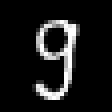

In [35]:
mnist_view(dtst, 1, 1)

If we take the corresponding column of the prediction and sort it by the predicted signal strengthes, we see that this 9 is mistaken for a 3.

In [38]:
order = sortperm(ypred[:, 1], rev=true)
collect(zip(order, ypred[order, 1]))

10-element Array{Tuple{Int64,Float32},1}:
 (3, 12.0134)  
 (9, 6.3246)   
 (5, 2.71294)  
 (8, 2.0547)   
 (7, -1.86479) 
 (4, -2.42487) 
 (10, -2.76917)
 (2, -3.74689) 
 (1, -4.44269) 
 (6, -8.67669) 

## Study Questions (not assessed)

####  Multilayer Perceptron model from Lecture 9

- What is the total number of pixels in each MNIST input image?
   - How many total input values are there to the model? (Understand why.)
   - How many total output values? (Understand why.)

- How many total parameters are there to the model? (Note that the parameters object `w` is a two-element array including both the large *weight* matrix and the smaller *bias* vector, which together compose the parameters of the model.)

- What is the number of input values to the input layer?

- What is the number of output values to the input layer (and hence the number of inputs to the first hidden layer)?

- What is the number of output values to the first hidden layer (and hence the number of input values to the second hidden layer)?

- What is the number of output values to the second hidden layer?

- How many total parameters are there, including the weight matrices and bias vectors for all layers? (Note that in this model the parameters array `w` has more than two elements. Understand why.)

### Convolutional Neural Network model from Lecture 10

For the model as defined by the `initweights()` function (see also the corresponding `nnPredict` function which shows how to get to a prediction given the weights and an input), determine:

- How many weights are in the first convolutional layer? (Not including the bias vector)
- How many weights are in the second convolutional layer? (Not including the bias vector)
- How many weights are in the next fully-connected layer? (Not including the bias vector)
- How many weights are in the final layer? (Not including the bias vector)
- How many weights are in the entire set of parameters (including all bias vectors)?
- Which two digits  are most likely to be misclassified by the trained model?

## Conclusion

Contained in this example are nearly all the important ideas you'll need to start attacking problems in computer vision. While state-of-the-art vision systems incorporate a few more bells and whistles, they're all built on this foundation. Believe it or not, if you knew just the content in this tutorial 5 years ago, you could probably have sold a startup to a Fortune 500 company for millions of dollars. Fortunately (or unfortunately?), the world has gotten marginally more sophisticated, so we'll have to come up with some more sophisticated tutorials to follow.